 # Phase 2: Time-to-maturity and average equity month range test

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import matplotlib.pyplot as plt
from matplotlib import style
import calendar
import math
from scipy import stats
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_data(formation_date, data_universe, equity_data, bond_data, fama_data, TMT):
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = 12)
    
    bond_data_ = bond_data[(bond_data.DATE >= form_date) & (bond_data.DATE <= limitf_date) & (bond_data.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM', 'DURATION'])['company_symbol'].unique())
    
    #equity  
    avg_date =  form_date - relativedelta.relativedelta(months = 12)
    #limitavg_date =  form_date + relativedelta.relativedelta(months = 12)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date > avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == 12].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    
    #fama
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
        
    bond_data___ = pd.merge(bond_data__, fama_data[['dateem', 'rf']], how='left', left_on = ['DATE'], right_on=['dateem'])
    bond_data___.YIELD = bond_data___.YIELD.str.replace('%', '').astype('float').divide(100.0)
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    
    equity_data___ = pd.merge(equity_data__, fama_data[['dateff', 'rf']], how='left', left_on = ['date'], right_on=['dateff'])

    return(equity_data___, bond_data___)

In [4]:
def rank_port_decile(equity_data , formation_date, num_month, strat_type = 0):
    
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    avg_date =  form_date - relativedelta.relativedelta(months = num_month)
    check_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, check_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date >= avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
    except:
        print('There is no C')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    #residual
    if strat_type != 0:
        equity_data_.RETX = equity_data_.RETX - equity_data_.rf
    
    #equity_data_.RETX = equity_data_.RETX.add(1) #cumulative
    
    equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'mean'})
    #equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'prod'}) #cumulative
    #equity_group_mean_ret = equity_group_mean_ret.subtract(1) #cumulative
    equity_group_mean_ret_sort = equity_group_mean_ret.sort_values(by=['RETX'])
    equity_group_mean_ret_sort['GROUP'] = 0
    
    frac = math.floor(equity_group_mean_ret_sort.shape[0]/10)
    num_line = equity_group_mean_ret_sort.shape[0]
    left = num_line-(frac*10)

    group_num = [frac+1]*(left)+[frac]*(10-left)
    group = ['P10', 'P09', 'P08', 'P07', 'P06', 'P05', 'P04', 'P03', 'P02', 'P01']
    
    i, j = 0, group_num[0]
    while j <= num_line:
        
        equity_group_mean_ret_sort.ix[(j-group_num[i]):j , 'GROUP'] = group[i]
        i +=1
        if(i == 10):
            break
        j = j + group_num[i]

    return(equity_group_mean_ret_sort)

In [5]:
def momentum_strategy_test(formation_date ,bond_data, rank_port, start_month, end_month):

    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    
    bond_data = pd.merge(bond_data, rank_port[['GROUP']], how = 'left', left_on = 'company_symbol', right_index=True)
    #bond_data = bond_data.dropna(subset=['RET_EOM', 'DURATION'])
    bond_data = bond_data.dropna(subset=['RET_EOM'])
    
    bond_average_month = bond_data.groupby(['month', 'company_symbol', 'GROUP']).agg({'PRICE_EOM':'mean','RET_EOM':'mean', 'RATING_NUM':'mean', 'DURATION':'mean'})

    bond_month = pd.DataFrame(columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration'])
    bond_month['month'] = [i[0] for i in bond_average_month.index]
    bond_month['ticker'] = [i[1] for i in bond_average_month.index]
    bond_month['port_group'] = [i[2] for i in bond_average_month.index]
    bond_month['price'] = bond_average_month['PRICE_EOM'].values
    bond_month['return'] = bond_average_month['RET_EOM'].values
    bond_month['avg_rating'] = bond_average_month['RATING_NUM'].values
    bond_month['duration'] = bond_average_month['DURATION'].values
    bond_hold = bond_month[(bond_month.month >= start_month) & (bond_month.month <= end_month)]
    
    bond_sum_price = bond_hold.groupby(['port_group', 'month']).agg({'price':'sum'})
    bond_sum_price['port_group'] = [i[0] for i in bond_sum_price.index]
    bond_sum_price['month'] = [i[1] for i in bond_sum_price.index]
    
    bond_hold_value = pd.merge(bond_hold, bond_sum_price, how = 'left', left_on = ['port_group', 'month'], right_on=['port_group', 'month'])
    bond_hold_value.columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration','port_total_weight']
    bond_hold_value['port_weight'] = bond_hold_value['price'].divide(bond_hold_value['port_total_weight'])
    bond_hold_value['value_return'] = bond_hold_value['return'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_price'] = bond_hold_value['price'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_rating'] = bond_hold_value['avg_rating'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_duration'] = bond_hold_value['duration'].mul(bond_hold_value['port_weight'])
    
    # Value portfolio
    bond_hold_value_ = bond_hold_value.groupby(['port_group', 'month']).agg({'value_return':'sum', 'value_price':'sum', 'value_duration':'sum', 'value_rating':'sum'})
    bond_hold_value_['port_group'] = [i[0] for i in bond_hold_value_.index]
    bond_hold_value_['month'] = [i[1] for i in bond_hold_value_.index]
    bond_hold_value_['value_return'] = bond_hold_value_['value_return'].add(1)
    bond_hold_value_['cumulative_return'] = bond_hold_value_.groupby(['port_group']).cumprod()['value_return']
    bond_hold_value_['cumulative_return']  = bond_hold_value_['cumulative_return'] .subtract(1)
    bond_hold_value_['value_return']  = bond_hold_value_['value_return'] .subtract(1)
    
    #Equal portfolio
    bond_hold_value___ = bond_hold_value
    bond_hold_equal = bond_hold_value___.groupby(['port_group', 'month']).agg({'return':'mean', 'price':'mean', 'duration':'mean', 'avg_rating':'mean'})
    bond_hold_equal['port_group'] = [i[0] for i in bond_hold_equal.index]
    bond_hold_equal['month'] = [i[1] for i in bond_hold_equal.index]
    bond_hold_equal['return'] = bond_hold_equal['return'].add(1)
    bond_hold_equal['cumulative_return'] = bond_hold_equal.groupby(['port_group']).cumprod()['return']
    bond_hold_equal['cumulative_return']  = bond_hold_equal['cumulative_return'] .subtract(1)
    bond_hold_equal['return']  = bond_hold_equal['return'] .subtract(1)
    
    
    col_name = []
    port = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10']
    col_name.append('month')
    for i in ['value', 'equal']:
        for j in port:
            col_name.append('{0}_{1}'.format(i, j))
    
    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(start_month, end_month+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    result = pd.DataFrame(data = 0, columns = col_name, index=index_name)
    result['month'] = range(start_month, end_month+1)

    for i in port:
        sub_index = bond_hold_value_[bond_hold_value_['port_group'] == i]['month'].values
        result.ix[result.month.isin(sub_index), '{0}_{1}'.format('value', i)] = bond_hold_value_[bond_hold_value_['port_group'] == i]['value_return'].values
        
    for i in port:
        sub_index = bond_hold_equal[bond_hold_equal['port_group'] == i]['month'].values
        result.ix[result.month.isin(sub_index), '{0}_{1}'.format('equal', i)] = bond_hold_equal[ bond_hold_equal['port_group'] == i]['return'].values
    
    result['value_P01-P10'] = result['value_P01'] - result['value_P10']
    result['equal_P01-P10'] = result['equal_P01'] - result['equal_P10']
    
    return(result)

In [6]:
def performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period = 12, TMT = 2, strat_type = 0):

    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    
    test_list = []
    test_list.append(0)
    for i in range(0, (int(test_period/holding_range[1])-1)):
        test_list.append(test_list[i]+holding_range[1])    
    
    current_form_date = form_date

    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(0, test_period+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    perf_ = pd.DataFrame(data = 0, columns = ['value_return {0}'.format(holding_range), 'equal_return {0}'.format(holding_range)],
                                   index = index_name)
    perf = pd.DataFrame()
    for i in test_list:
        try:
            current_form_date =  form_date + relativedelta.relativedelta(months = i)

            check_last_day = calendar.monthrange(current_form_date.year, current_form_date.month)
            current_form_date = datetime(current_form_date.year, current_form_date.month, check_last_day[-1])

            current_equity_data, current_bond_data = generate_data(current_form_date.strftime('%Y-%m-%d'), data_universe, equity_data_raw, bond_data_raw, fama_data_raw, TMT)

            current_rank_port = rank_port_decile(current_equity_data, current_form_date.strftime('%Y-%m-%d'), avg_range, strat_type = strat_type)

            current_perf = momentum_strategy_test(current_form_date.strftime('%Y-%m-%d'), current_bond_data, current_rank_port, holding_range[0], holding_range[1])
            perf = perf.append(current_perf.iloc[:, 21:23])
        except Exception as e:
            print(e)
            break
    perf = perf.add(1)
    perf['Date'] =  perf.index
    perf.columns
    perf = perf.groupby(['Date']).agg({'value_P01-P10': 'prod', 'equal_P01-P10': 'prod'})
    perf = perf.subtract(1)
    perf.columns = ['value_return {0}'.format(holding_range), 'equal_return {0}'.format(holding_range)]
    perf_[perf_.index.isin(perf.index)] = perf
    
    perf_['value_cum_return {0}'.format(holding_range)] = perf_.iloc[:, 0].add(1).cumprod().subtract(1)
    perf_['equal_cum_return {0}'.format(holding_range)] = perf_.iloc[:, 1].add(1).cumprod().subtract(1)

    return(perf_)

In [7]:
def get_risk_indicator(perf, data_universe):
    
    if data_universe == 'IG':
        index_data = pd.read_csv('index_IG.csv')
    elif data_universe == 'HY':
        index_data = pd.read_csv('index_HY.csv')
    else:
        index_data = pd.read_csv('index_BBB.csv')
    
    index_data.Date = index_data.Date.apply(lambda x: datetime.strptime(str(x), '%m/%d/%Y'))
    
    fama_data = fama_data_raw
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
    index_data['dateem'] = pd.to_datetime(pd.PeriodIndex(index_data.Date, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d')
    
    holding_range = eval(perf.columns[0][13:len(perf.columns[0])])
    perf['date'] = perf.index.values
    
    perf_ = pd.merge(perf, fama_data[['dateem', 'rf']], how='left', left_on = ['date'], right_on=['dateem'])
    perf_ = pd.merge(perf_, index_data[['dateem', 'index_return']], how='left', left_on = ['date'], right_on=['dateem'])
    perf__ = perf_.iloc[:,0:2].subtract(perf_['rf'], axis=0)
    
    perf__['value_cum_return {0}'.format(holding_range)] = perf__.iloc[:, 0].add(1).cumprod().subtract(1)
    perf__['equal_cum_return {0}'.format(holding_range)] = perf__.iloc[:, 1].add(1).cumprod().subtract(1)
    perf__['rf'] = perf_['rf']
    perf__['index_return_{0}'.format(data_universe)] = perf_['index_return'] - perf_['rf']
    
    index_name = ['Excess annual return', 'Excess cumulative return','Excess mean return', 'Volatility', 'Annualized Sharpe ratio',
                  'Alpha', 'Beta','Skewness', 'Kurtosis', 'MaxDD', 'VaR', 'CVaR', 'Rebalancing']
    result = pd.DataFrame(columns = perf__.iloc[:,0:2].columns, index = index_name)
    
    for i in perf_.iloc[:,0:2].columns:
        pert_temp = perf__.ix[:, i]
        
        annual_ret = pert_temp.add(1).prod()** (12 / len(pert_temp)) - 1
        mean_ret = stats.mstats.gmean(pert_temp.add(1), axis=0)-1
        volatility = np.std(pert_temp, axis=0)
        sharpe = (pert_temp.mean()*np.sqrt(12))/(volatility*(12**(1/2)))
        
        cross_regres = sm.OLS(pert_temp, sm.add_constant(perf__['index_return_{0}'.format(data_universe)])).fit().params.values
        alpha = cross_regres[0]
        beta = cross_regres[1]
        
        skewness = stats.skew(pert_temp, axis=0)
        kurtosis = stats.kurtosis(pert_temp, axis=0)
        
        cum_returns = pert_temp.add(1).cumprod()
        drawdown =  cum_returns.div(cum_returns.cummax())-1
        max_dd = min(drawdown)
        
        VaR_list = np.percentile(pert_temp.values, .01)
        CVaR_list = np.mean(np.sort(pert_temp.values)[np.sort(pert_temp.values) <= np.percentile(pert_temp, .01)])
         
        rebalancing = int((len(pert_temp) - 1)/holding_range[-1])
        
        r_list = [annual_ret, cum_returns.subtract(1).values[-1],mean_ret, volatility, sharpe, alpha, beta, skewness, kurtosis, max_dd, VaR_list, CVaR_list, rebalancing]
        
        result.ix[:, i] = r_list
        
    result.loc['date'] = [perf.date.values[0], perf.date.values[-1]]
    performance = perf__
    performance['index_cum_return_{0}'.format(data_universe)] = perf__.ix[:, 'index_return_{0}'.format(data_universe)].add(1).cumprod().subtract(1)
    performance.index = perf.index
    
    return(result, performance)

In [8]:
def test_avg_month(perf_list):
    
    col_name = ['Excess annual return', 'Excess cumulative return',
       'Excess mean return', 'Volatility', 'Annualized Sharpe ratio',
       'Skewness', 'Kurtosis', 'MaxDD', 'VaR', 'CVaR']
    
    df = pd.DataFrame(columns = col_name, index= ['TMT-{0}'.format(i) for i in range(1, len(perf_list)+1)])

    df['Excess annual return'] = [i.iloc[0,:].values[1] for i in perf_list]
    df['Excess cumulative return'] = [i.iloc[1,:].values[1] for i in perf_list]
    df['Excess mean return'] = [i.iloc[2,:].values[1] for i in perf_list]
    df['Volatility'] = [i.iloc[3,:].values[1] for i in perf_list]
    df['Annualized Sharpe ratio'] = [i.iloc[4,:].values[1] for i in perf_list]
    df['Alpha'] = [i.iloc[5,:].values[1] for i in perf_list]
    df['Beta'] = [i.iloc[6,:].values[1] for i in perf_list]
    df['Skewness'] = [i.iloc[7,:].values[1] for i in perf_list]
    df['Kurtosis'] = [i.iloc[8,:].values[1] for i in perf_list]
    df['MaxDD'] = [i.iloc[9,:].values[1] for i in perf_list]
    df['VaR'] = [i.iloc[10,:].values[1] for i in perf_list]
    df['CVaR'] = [i.iloc[11,:].values[1] for i in perf_list]

    return(df)

# Backtesting

Bond data, equity data, risk-free rate data from 2002 - 2018

In [9]:
bond_data_raw = pd.read_csv('bond_data.txt', sep='\t')
bond_data_raw.DATE = pd.to_datetime(bond_data_raw.DATE, format = '%d%b%Y')

equity_data_raw = pd.read_csv('equity_data.txt', sep='\t')
equity_data_raw.date = pd.to_datetime(equity_data_raw.date, format = '%Y%m%d')

fama_data_raw = pd.read_csv('fama_data.txt', sep='\t')
fama_data_raw.dateff = pd.to_datetime(fama_data_raw.dateff, format = '%Y%m%d')

First formation date

In [10]:
formation_date = '2003-12-31'

total momentum stratey, holding the bonds in the first month after the formation date and test 13 years. We exclude time-to-maturity one by one to see which range can make the best performance

In [11]:
strat_type = 0
holding_range = (0, 1)
test_period = 12*13

## IG universe

In [65]:
data_universe = 'IG'

### Average 3 - IG

In [66]:
test_list_IG3 = []
avg_range = 3
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_IG3.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [67]:
df_IG3 = test_avg_month(test_list_IG3)

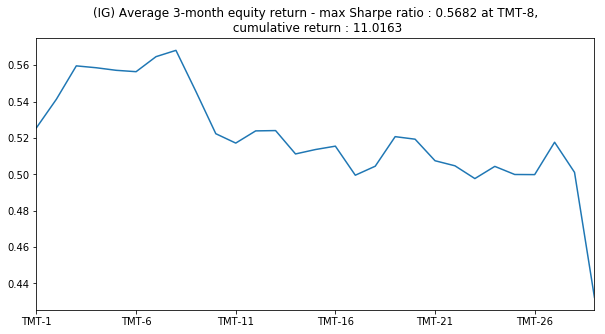

In [68]:
df_IG3['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
                                       '(IG) Average 3-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG3['Annualized Sharpe ratio'].max(),
                                                     df_IG3['Annualized Sharpe ratio'].idxmax(), df_IG3.ix[df_IG3['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

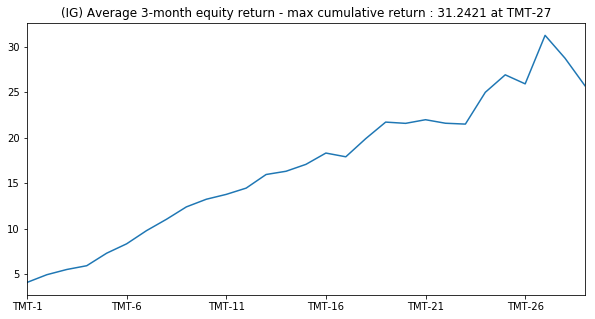

In [69]:
df_IG3['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(IG) Average 3-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_IG3['Excess cumulative return'].max(),
                                                     df_IG3['Excess cumulative return'].idxmax()))

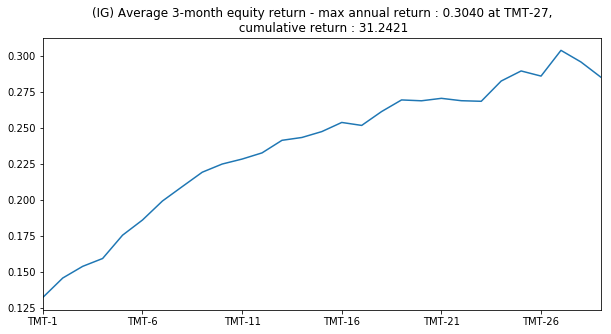

In [77]:
df_IG3['Excess annual return'].plot(figsize=(10,5), title = 
       '(IG) Average 3-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG3['Excess annual return'].max(),
                                                     df_IG3['Excess annual return'].idxmax(), df_IG3.ix[df_IG3['Excess annual return'].idxmax(), 'Excess cumulative return']))

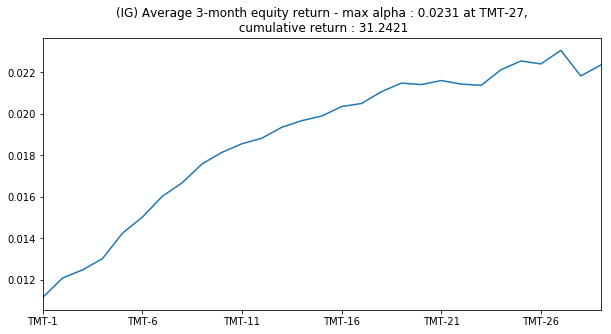

In [71]:
df_IG3['Alpha'].plot(figsize=(10,5), title = 
       '(IG) Average 3-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG3['Alpha'].max(),
                                                     df_IG3['Alpha'].idxmax(), df_IG3.ix[df_IG3['Alpha'].idxmax(), 'Excess cumulative return']))

### Average 6 - IG

In [72]:
test_list_IG6 = []
avg_range = 6
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_IG6.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


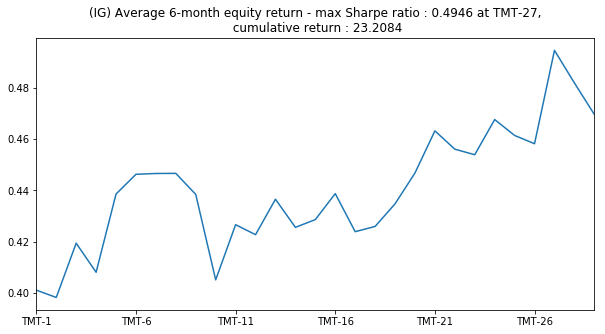

In [73]:
df_IG6 = test_avg_month(test_list_IG6)
df_IG6['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(IG) Average 6-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG6['Annualized Sharpe ratio'].max(),
                                                     df_IG6['Annualized Sharpe ratio'].idxmax(), df_IG6.ix[df_IG6['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

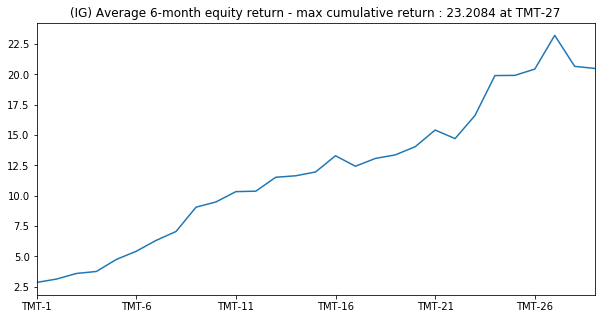

In [74]:
df_IG6['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(IG) Average 6-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_IG6['Excess cumulative return'].max(),
                                                     df_IG6['Excess cumulative return'].idxmax()))

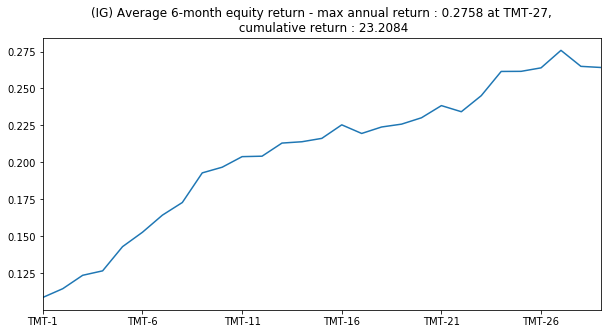

In [86]:
df_IG6['Excess annual return'].plot(figsize=(10,5), title = 
       '(IG) Average 6-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG6['Excess annual return'].max(),
                                                     df_IG6['Excess annual return'].idxmax(), df_IG6.ix[df_IG6['Excess annual return'].idxmax(), 'Excess cumulative return']))

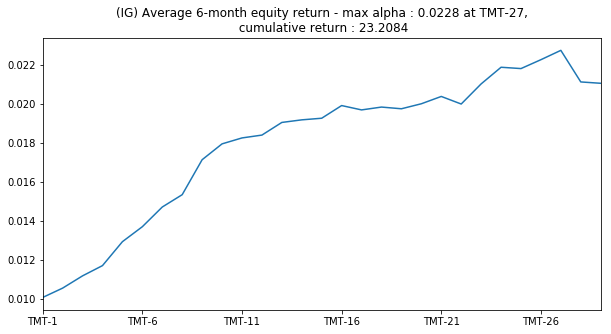

In [76]:
df_IG6['Alpha'].plot(figsize=(10,5), title = 
       '(IG) Average 6-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG6['Alpha'].max(),
                                                     df_IG6['Alpha'].idxmax(), df_IG6.ix[df_IG6['Alpha'].idxmax(), 'Excess cumulative return']))

### Average 12 - IG

In [13]:
test_list_IG12 = []
avg_range = 12
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_IG12.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


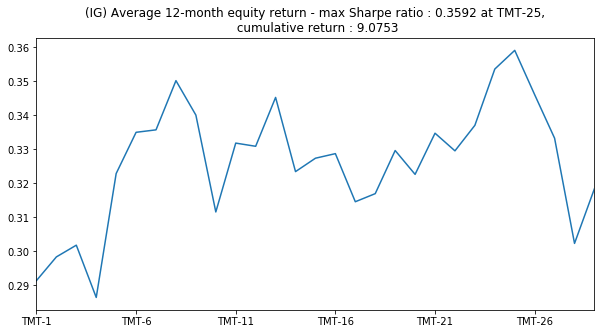

In [14]:
df_IG12 = test_avg_month(test_list_IG12)
df_IG12['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(IG) Average 12-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG12['Annualized Sharpe ratio'].max(),
                                                     df_IG12['Annualized Sharpe ratio'].idxmax(), df_IG12.ix[df_IG12['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

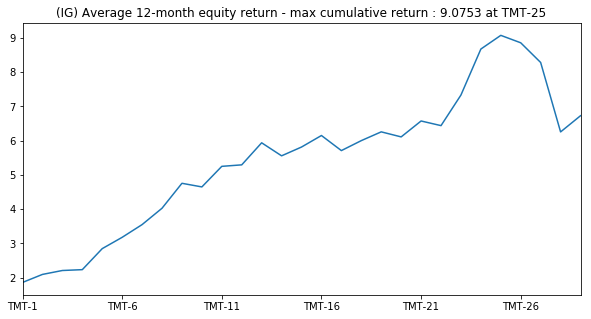

In [15]:
df_IG12['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(IG) Average 12-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_IG12['Excess cumulative return'].max(),
                                                     df_IG12['Excess cumulative return'].idxmax()))

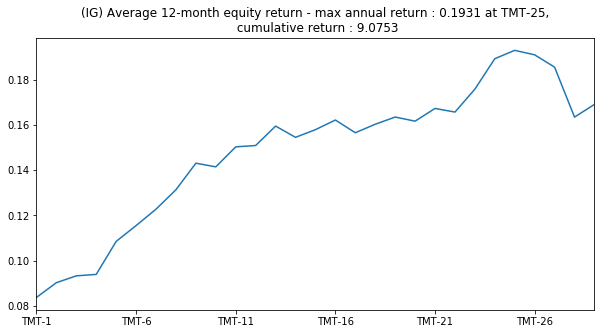

In [79]:
df_IG12['Excess annual return'].plot(figsize=(10,5), title = 
       '(IG) Average 12-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG12['Excess annual return'].max(),
                                                     df_IG12['Excess annual return'].idxmax(), df_IG12.ix[df_IG12['Excess annual return'].idxmax(), 'Excess cumulative return']))

In [ ]:
df_IG12['Alpha'].plot(figsize=(10,5), title = 
       '(IG) Average 12-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_IG12['Alpha'].max(),
                                                     df_IG12['Alpha'].idxmax(), df_IG12.ix[df_IG12['Alpha'].idxmax(), 'Excess cumulative return']))

## BBB universe

### Average 3 - BBB

In [18]:
data_universe = 'BBB'

In [19]:
test_list_BBB3 = []
avg_range = 3
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_BBB3.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


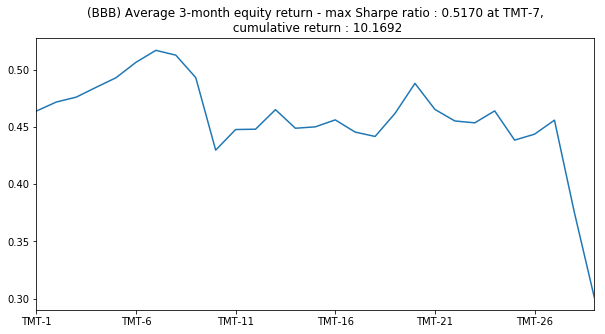

In [20]:
df_BBB3 = test_avg_month(test_list_BBB3)
df_BBB3['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(BBB) Average 3-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB3['Annualized Sharpe ratio'].max(),
                                                     df_BBB3['Annualized Sharpe ratio'].idxmax(), df_BBB3.ix[df_BBB3['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

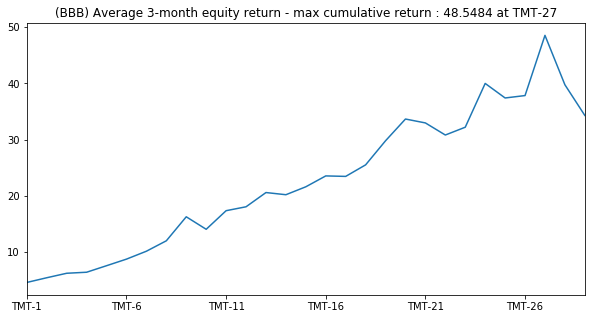

In [87]:
df_BBB3['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(BBB) Average 3-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_BBB3['Excess cumulative return'].max(),
                                                     df_BBB3['Excess cumulative return'].idxmax()))

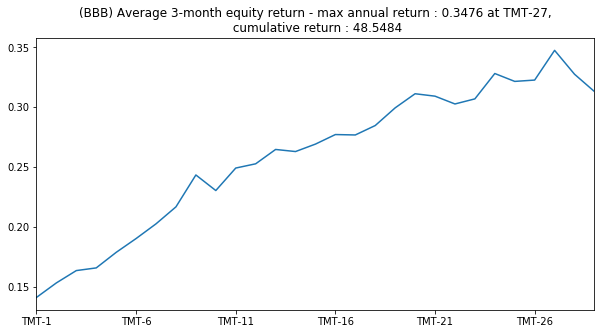

In [88]:
df_BBB3['Excess annual return'].plot(figsize=(10,5), title = 
       '(BBB) Average 3-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB3['Excess annual return'].max(),
                                                     df_BBB3['Excess annual return'].idxmax(), df_BBB3.ix[df_BBB3['Excess annual return'].idxmax(), 'Excess cumulative return']))

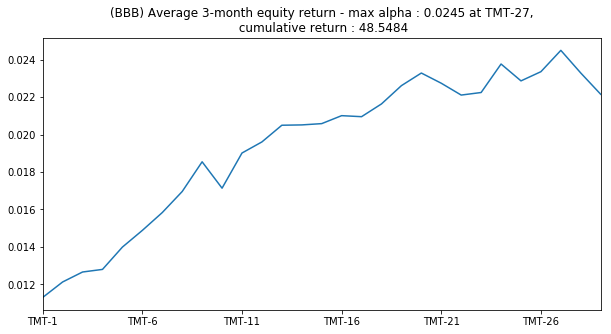

In [22]:
df_BBB3['Alpha'].plot(figsize=(10,5), title = 
       '(BBB) Average 3-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB3['Alpha'].max(),
                                                     df_BBB3['Alpha'].idxmax(), df_BBB3.ix[df_BBB3['Alpha'].idxmax(), 'Excess cumulative return']))

### Average 6 - BBB

In [23]:
test_list_BBB6 = []
avg_range = 6
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_BBB6.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


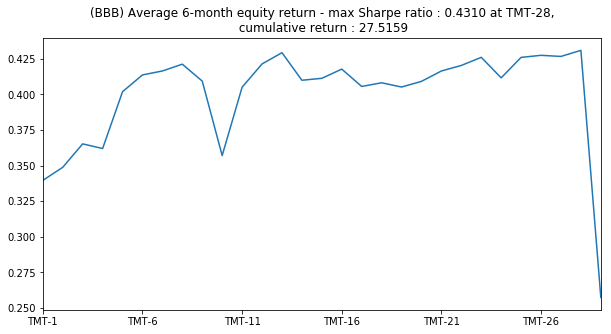

In [24]:
df_BBB6 = test_avg_month(test_list_BBB6)
df_BBB6['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(BBB) Average 6-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB6['Annualized Sharpe ratio'].max(),
                                                     df_BBB6['Annualized Sharpe ratio'].idxmax(), df_BBB6.ix[df_BBB6['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

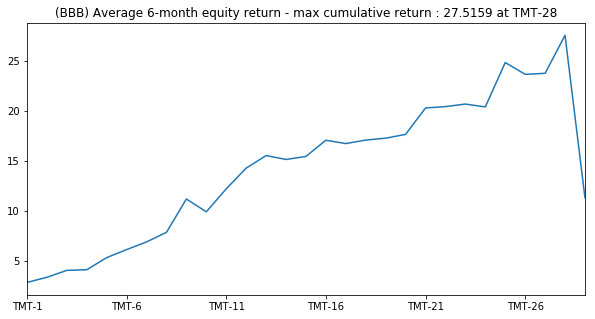

In [25]:
df_BBB6['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(BBB) Average 6-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_BBB6['Excess cumulative return'].max(),
                                                     df_BBB6['Excess cumulative return'].idxmax()))



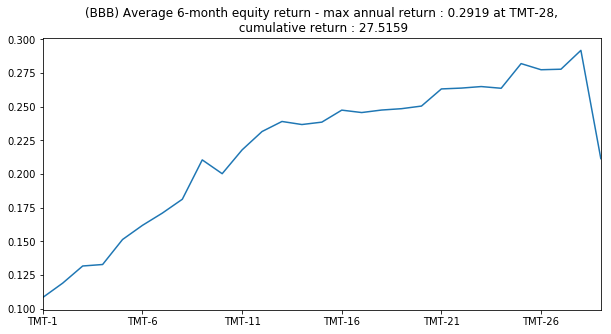

In [81]:
df_BBB6['Excess annual return'].plot(figsize=(10,5), title = 
       '(BBB) Average 6-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB6['Excess annual return'].max(),
                                                     df_BBB6['Excess annual return'].idxmax(), df_BBB6.ix[df_BBB6['Excess annual return'].idxmax(), 'Excess cumulative return']))

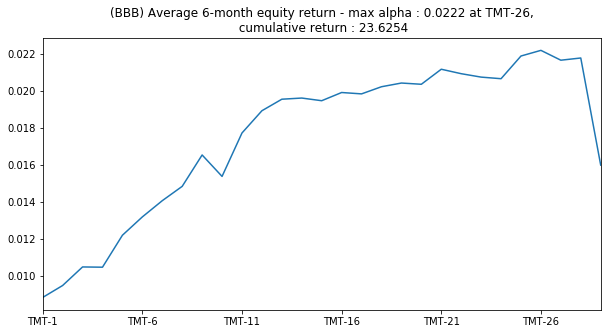

In [26]:
df_BBB6['Alpha'].plot(figsize=(10,5), title = 
       '(BBB) Average 6-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB6['Alpha'].max(),
                                                     df_BBB6['Alpha'].idxmax(), df_BBB6.ix[df_BBB6['Alpha'].idxmax(), 'Excess cumulative return']))

### Average 12 - BBB

In [27]:
test_list_BBB12 = []
avg_range = 12
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_BBB12.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


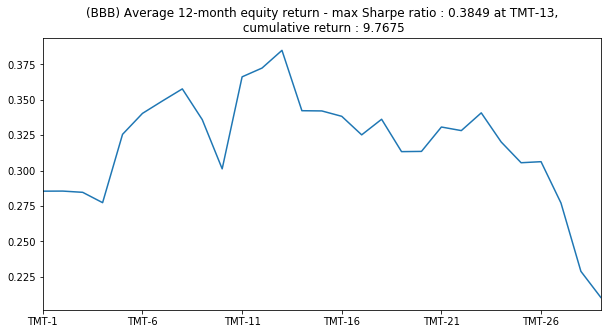

In [30]:
df_BBB12 = test_avg_month(test_list_BBB12)
df_BBB12['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(BBB) Average 12-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB12['Annualized Sharpe ratio'].max(),
                                                     df_BBB12['Annualized Sharpe ratio'].idxmax(), df_BBB12.ix[df_BBB12['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

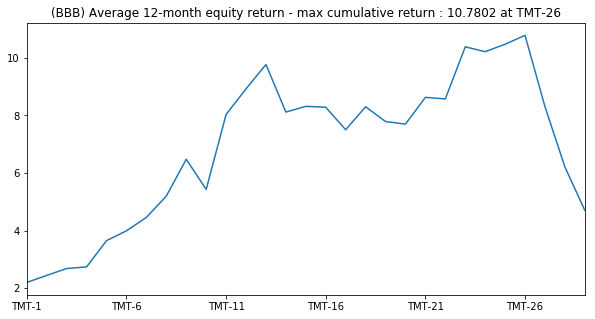

In [31]:
df_BBB12['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(BBB) Average 12-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_BBB12['Excess cumulative return'].max(),
                                                     df_BBB12['Excess cumulative return'].idxmax()))

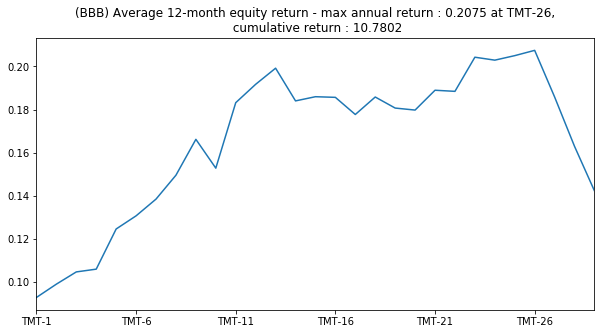

In [82]:
df_BBB12['Excess annual return'].plot(figsize=(10,5), title = 
       '(BBB) Average 12-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB12['Excess annual return'].max(),
                                                     df_BBB12['Excess annual return'].idxmax(), df_BBB12.ix[df_BBB12['Excess annual return'].idxmax(), 'Excess cumulative return']))

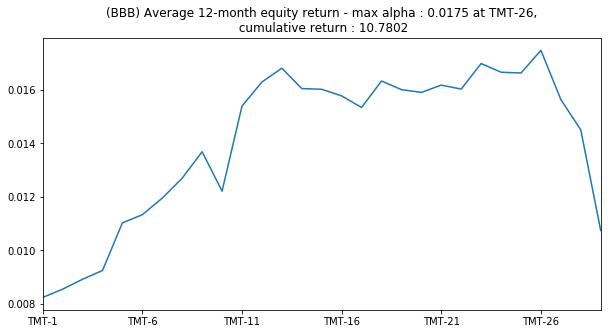

In [29]:
df_BBB12['Alpha'].plot(figsize=(10,5), title = 
       '(BBB) Average 12-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_BBB12['Alpha'].max(),
                                                     df_BBB12['Alpha'].idxmax(), df_BBB12.ix[df_BBB12['Alpha'].idxmax(), 'Excess cumulative return']))

## HY universe

### Average 3 - HY

In [32]:
data_universe = 'HY'

In [33]:
test_list_HY3 = []
avg_range = 3
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_HY3.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


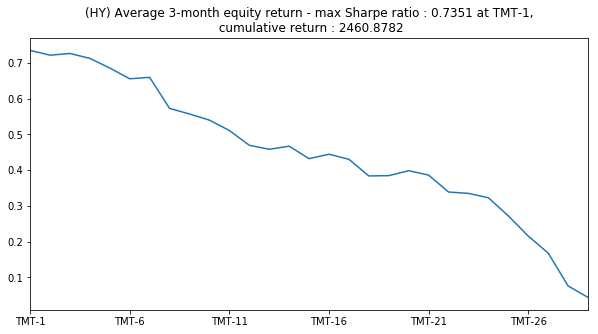

In [34]:
df_HY3 = test_avg_month(test_list_HY3)
df_HY3['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(HY) Average 3-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY3['Annualized Sharpe ratio'].max(),
                                                     df_HY3['Annualized Sharpe ratio'].idxmax(), df_HY3.ix[df_HY3['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

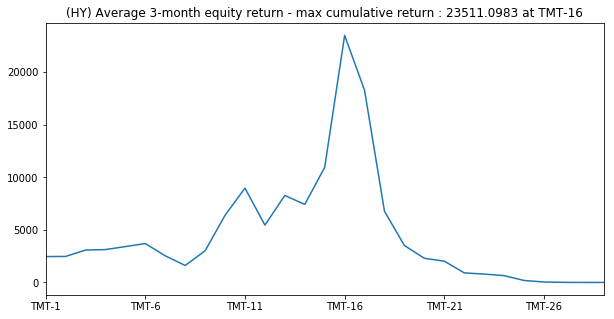

In [35]:
df_HY3['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(HY) Average 3-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_HY3['Excess cumulative return'].max(),
                                                     df_HY3['Excess cumulative return'].idxmax()))

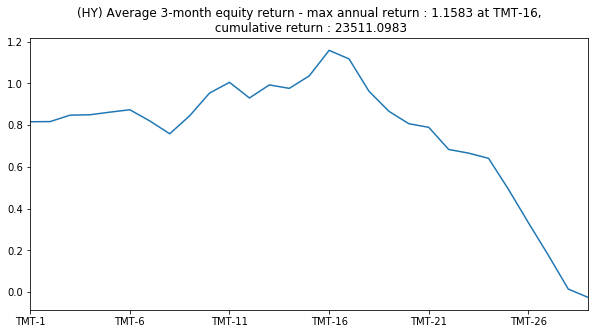

In [83]:
df_HY3['Excess annual return'].plot(figsize=(10,5), title = 
       '(HY) Average 3-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY3['Excess annual return'].max(),
                                                     df_HY3['Excess annual return'].idxmax(), df_HY3.ix[df_HY3['Excess annual return'].idxmax(), 'Excess cumulative return']))

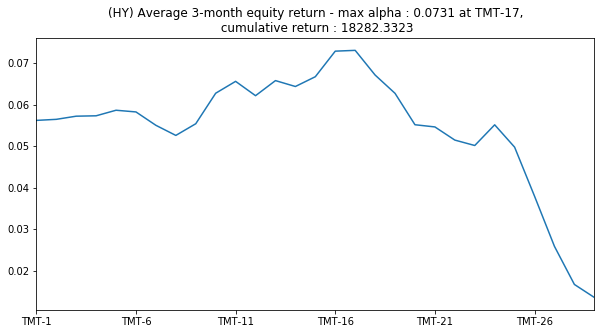

In [36]:
df_HY3['Alpha'].plot(figsize=(10,5), title = 
       '(HY) Average 3-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY3['Alpha'].max(),
                                                     df_HY3['Alpha'].idxmax(), df_HY3.ix[df_HY3['Alpha'].idxmax(), 'Excess cumulative return']))

### Average 6 - HY

In [37]:
test_list_HY6 = []
avg_range = 6
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_HY6.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


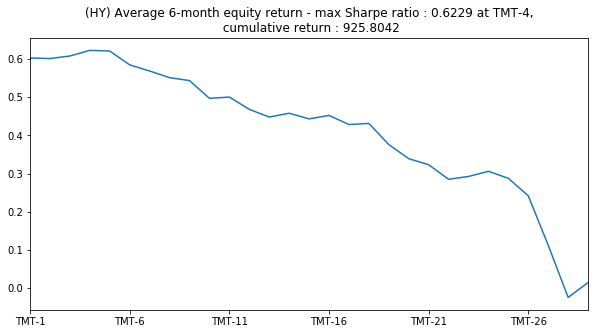

In [38]:
df_HY6 = test_avg_month(test_list_HY6)
df_HY6['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(HY) Average 6-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY6['Annualized Sharpe ratio'].max(),
                                                     df_HY6['Annualized Sharpe ratio'].idxmax(), df_HY6.ix[df_HY6['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

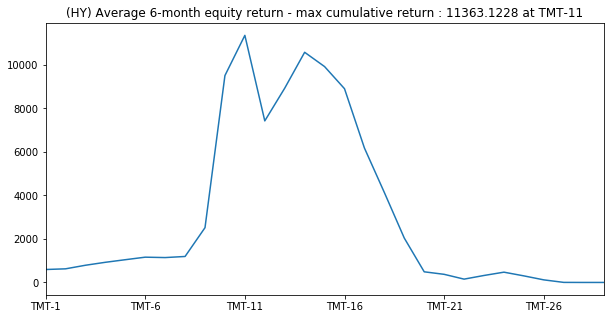

In [39]:
df_HY6['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(HY) Average 6-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_HY6['Excess cumulative return'].max(),
                                                     df_HY6['Excess cumulative return'].idxmax()))

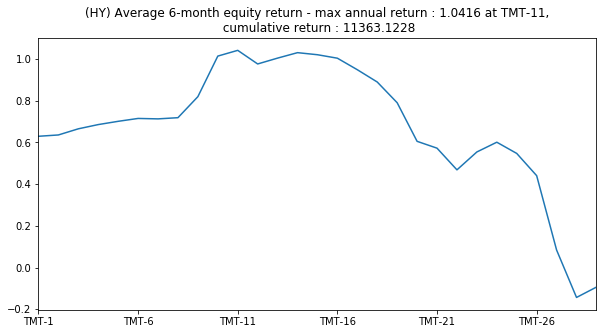

In [84]:
df_HY6['Excess annual return'].plot(figsize=(10,5), title = 
       '(HY) Average 6-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY6['Excess annual return'].max(),
                                                     df_HY6['Excess annual return'].idxmax(), df_HY6.ix[df_HY6['Excess annual return'].idxmax(), 'Excess cumulative return']))

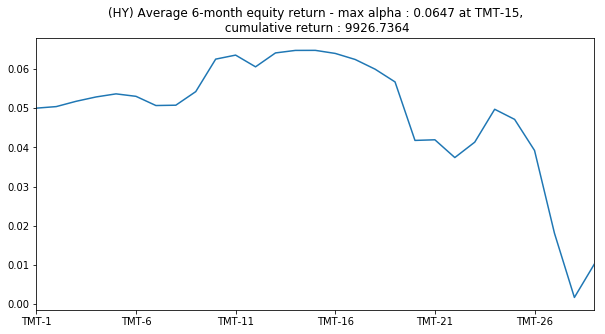

In [40]:
df_HY6['Alpha'].plot(figsize=(10,5), title = 
       '(HY) Average 6-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY6['Alpha'].max(),
                                                     df_HY6['Alpha'].idxmax(), df_HY6.ix[df_HY6['Alpha'].idxmax(), 'Excess cumulative return']))

### Average 12 - HY

In [41]:
test_list_HY12 = []
avg_range = 12
for i in range(1, 30):
    print(i)
    perf_test = performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period, TMT=i)
    risk_perf, temp_index = get_risk_indicator(perf_test, data_universe)
    test_list_HY12.append(risk_perf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


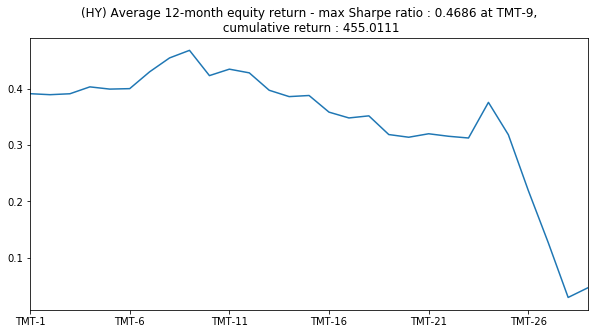

In [42]:
df_HY12 = test_avg_month(test_list_HY12)
df_HY12['Annualized Sharpe ratio'].plot(figsize=(10,5), title = 
       '(HY) Average 12-month equity return - max Sharpe ratio : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY12['Annualized Sharpe ratio'].max(),
                                                     df_HY12['Annualized Sharpe ratio'].idxmax(), df_HY12.ix[df_HY12['Annualized Sharpe ratio'].idxmax(), 'Excess cumulative return']))

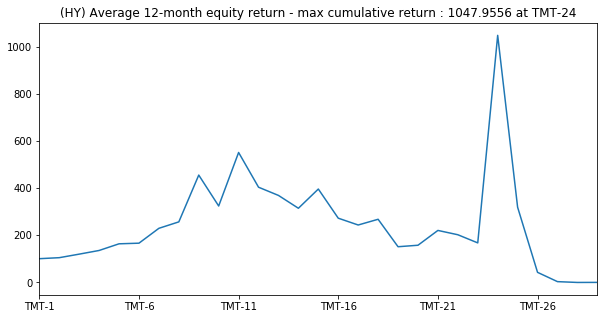

In [43]:
df_HY12['Excess cumulative return'].plot(figsize=(10,5), title = 
       '(HY) Average 12-month equity return - max cumulative return : {0:.4f} at {1}'.format(df_HY12['Excess cumulative return'].max(),
                                                     df_HY12['Excess cumulative return'].idxmax()))

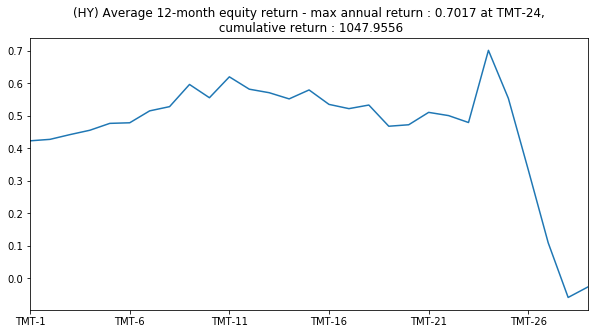

In [85]:
df_HY12['Excess annual return'].plot(figsize=(10,5), title = 
       '(HY) Average 12-month equity return - max annual return : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY12['Excess annual return'].max(),
                                                     df_HY12['Excess annual return'].idxmax(), df_HY12.ix[df_HY12['Excess annual return'].idxmax(), 'Excess cumulative return']))

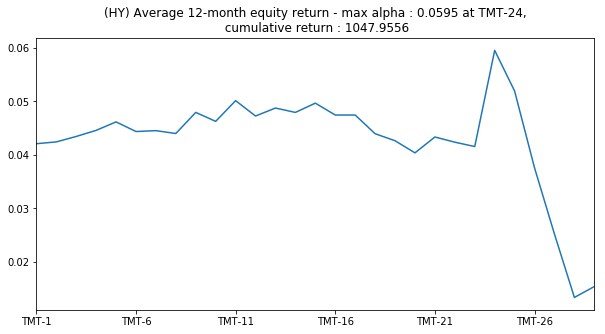

In [44]:
df_HY12['Alpha'].plot(figsize=(10,5), title = 
       '(HY) Average 12-month equity return - max alpha : {0:.4f} at {1},\n cumulative return : {2:.4f}'.format(df_HY12['Alpha'].max(),
                                                     df_HY12['Alpha'].idxmax(), df_HY12.ix[df_HY12['Alpha'].idxmax(), 'Excess cumulative return']))

Based on testing from 2004 to 2016, the best systematic strategy is: high-yield bonds with average 3-month equity return and time-to-maturity over 16 years.